### Imports

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization,RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

2025-02-23 18:44:22.423423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740329062.443848    1310 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740329062.449584    1310 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 18:44:22.470351: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### ResNet Model

In [3]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Make the last layers trainable
base_model.trainable = True
# Keep first 100 layers frozen
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add custom classification layers for CIFAR-10 (10 classes)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
output = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)


# Define the final model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# print the number of layers in the model
print("Model has total layers = ",len(model.layers))
# Print model summary
model.summary()

I0000 00:00:1740329080.959985    1310 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model has total layers =  180


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 22,081,034 (84.23 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

### Loading the dataset

In [4]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"Original Train set: {x_train.shape}")
print(f"Original Test set: {x_test.shape}")

Original Train set: (50000, 32, 32, 3)
Original Test set: (10000, 32, 32, 3)


In [5]:
# Reserve 5000 samples from the training set for validation
x_train, x_dev = x_train[:45000], x_train[45000:]
y_train, y_dev = y_train[:45000], y_train[45000:]

print(f"Train set: {x_train.shape}")
print(f"Dev set: {x_dev.shape}")
print(f"Test set: {x_test.shape}")

Train set: (45000, 32, 32, 3)
Dev set: (5000, 32, 32, 3)
Test set: (10000, 32, 32, 3)


In [6]:
# Define batch size
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE  # Optimizes performance

# Function to resize and normalize images
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize dynamically
    image = preprocess_input(image)  # resnet50 preprocess
    return image, label

# Convert datasets to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dev_dataset = tf.data.Dataset.from_tensor_slices((x_dev, y_dev))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply preprocessing and batching
train_dataset = (
    train_dataset
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

dev_dataset = (
    dev_dataset
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_dataset = (
    test_dataset
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Print dataset structure
print(train_dataset)
print(dev_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


### Train the Model

In [7]:
# Train the model with a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, patience=3,
    min_lr=1e-6
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                 # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore the model from the best epoch
    verbose=1
)

# Train for more epochs (with data augmentation if needed)
history = model.fit(train_dataset, validation_data=dev_dataset, epochs=20, callbacks=[lr_scheduler, early_stopping])

Epoch 1/20


I0000 00:00:1740329142.681575    1607 service.cc:148] XLA service 0x7f3650004e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740329142.681766    1607 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-02-23 18:45:43.278318: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740329145.375371    1607 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-23 18:45:47.675307: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_con

703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8576 - loss: 0.4400

2025-02-23 18:51:34.295964: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-23 18:51:34.721766: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[8,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivati

704/704 ━━━━━━━━━━━━━━━━━━━━ 402s 519ms/step - accuracy: 0.8578 - loss: 0.4395 - val_accuracy: 0.9356 - val_loss: 0.1857 - learning_rate: 1.0000e-04
Epoch 2/20


2025-02-23 18:52:09.373333: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9737 - loss: 0.0772

2025-02-23 18:57:38.627300: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 348s 494ms/step - accuracy: 0.9737 - loss: 0.0772 - val_accuracy: 0.9178 - val_loss: 0.2872 - learning_rate: 1.0000e-04
Epoch 3/20


2025-02-23 18:57:57.392021: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 356s 506ms/step - accuracy: 0.9846 - loss: 0.0462 - val_accuracy: 0.9470 - val_loss: 0.2180 - learning_rate: 1.0000e-04
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 355s 504ms/step - accuracy: 0.9879 - loss: 0.0361 - val_accuracy: 0.9348 - val_loss: 0.2856 - learning_rate: 1.0000e-04
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 350s 497ms/step - accuracy: 0.9944 - loss: 0.0175 - val_accuracy: 0.9576 - val_loss: 0.1806 - learning_rate: 5.0000e-05
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9995 - loss: 0.0019

2025-02-23 19:21:15.505137: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 357s 506ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9610 - val_loss: 0.1885 - learning_rate: 5.0000e-05
Epoch 7/20


2025-02-23 19:21:34.740314: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 1.0000 - loss: 1.9511e-04

2025-02-23 19:27:13.031796: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 357s 508ms/step - accuracy: 1.0000 - loss: 1.9504e-04 - val_accuracy: 0.9624 - val_loss: 0.1917 - learning_rate: 5.0000e-05
Epoch 8/20


2025-02-23 19:27:32.142321: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 1.0000 - loss: 4.5590e-05

2025-02-23 19:33:04.121574: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 351s 498ms/step - accuracy: 1.0000 - loss: 4.5582e-05 - val_accuracy: 0.9618 - val_loss: 0.1964 - learning_rate: 5.0000e-05
Epoch 9/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 1.0000 - loss: 2.7007e-05

2025-02-23 19:38:50.381578: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 346s 492ms/step - accuracy: 1.0000 - loss: 2.7004e-05 - val_accuracy: 0.9622 - val_loss: 0.1991 - learning_rate: 2.5000e-05
Epoch 10/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 1.0000 - loss: 2.1306e-05

2025-02-23 19:44:36.667973: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


704/704 ━━━━━━━━━━━━━━━━━━━━ 346s 492ms/step - accuracy: 1.0000 - loss: 2.1304e-05 - val_accuracy: 0.9624 - val_loss: 0.2021 - learning_rate: 2.5000e-05
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


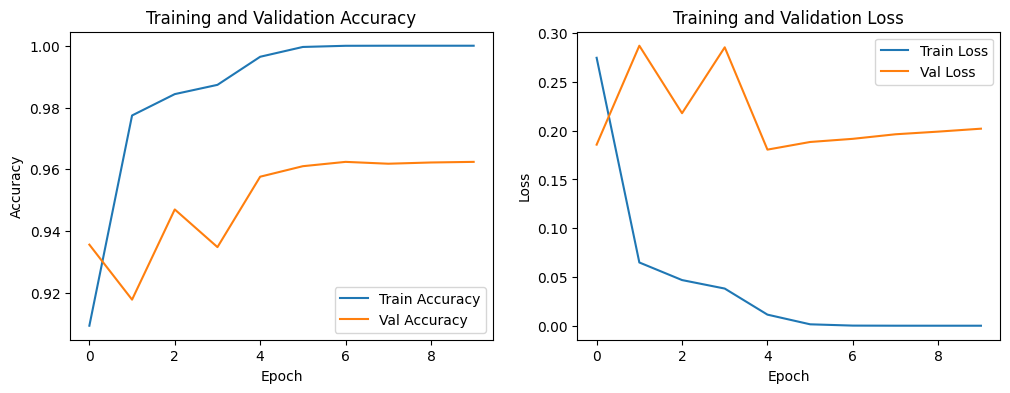

In [8]:
# Plot training and validation curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(history)

### Evaluate the model

In [9]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

2025-02-23 19:49:22.367706: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


156/157 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9559 - loss: 0.1827

2025-02-23 19:50:00.484183: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-23 19:50:01.049058: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 266ms/step - accuracy: 0.9559 - loss: 0.1828
Test Accuracy: 95.31%


In [10]:
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Predict on test data
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # True labels
y_pred = model.predict(test_dataset)  # Predictions from the model

# Convert predictions to class labels (max probability as class prediction)
y_pred_classes = np.argmax(y_pred, axis=1).flatten()  # Get class with max probability for each sample

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred_classes, target_names=['airplane', 'automobile', 'bird', 'cat', 'deer',
                                                                         'dog', 'frog', 'horse', 'ship', 'truck'])
print("Classification Report:")
print(class_report)

2025-02-23 19:50:07.435734: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-02-23 19:50:14.719132: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-23 19:50:14.772190: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-02-23 19:50:14.772569: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the fir

157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 276ms/step
Confusion Matrix:
[[973   2   5   2   1   0   2   1  12   2]
 [  2 984   0   0   0   0   0   0   0  14]
 [  9   0 927  17  13  18  13   1   2   0]
 [  4   1   4 902   7  60  11   6   1   4]
 [  4   2   7  22 941   8   4  12   0   0]
 [  0   1   4  54   5 924   4   8   0   0]
 [  3   0   5  10   1   2 979   0   0   0]
 [  1   0   2   1   8   6   0 982   0   0]
 [ 15  11   2   2   1   0   1   0 963   5]
 [  5  35   0   1   0   0   0   0   3 956]]
Classification Report:
              precision    recall  f1-score   support

    airplane       0.96      0.97      0.97      1000
  automobile       0.95      0.98      0.97      1000
        bird       0.97      0.93      0.95      1000
         cat       0.89      0.90      0.90      1000
        deer       0.96      0.94      0.95      1000
         dog       0.91      0.92      0.92      1000
        frog       0.97      0.98      0.97      1000
       horse       0.97      0.98      0.98      10

### Save the model

In [11]:
model_save_path = "./resnet50_cifar10.h5"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: ./resnet50_cifar10.h5


### Convert to tflite with fp-16 precision and INT8 fully quantized

In [ ]:
# Load the original model
model = tf.keras.models.load_model("./resnet50_cifar10.h5")
# Convert to float16 precision
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
# Save the reduced model
with open("model_fp16.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwysgeamg/assets


INFO:tensorflow:Assets written to: /tmp/tmpwysgeamg/assets


Saved artifact at '/tmp/tmpwysgeamg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140429063433168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140429063431440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497831440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497832400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497835856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497836432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497828752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497832016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497827792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497830096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497835

W0000 00:00:1739779079.811244     643 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739779079.811947     643 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-17 09:57:59.813304: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpwysgeamg
2025-02-17 09:57:59.835029: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-17 09:57:59.835058: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpwysgeamg
I0000 00:00:1739779079.970413     643 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-02-17 09:57:59.993367: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-17 09:58:01.057728: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpwysgeamg
2025-02-17 09:58:01.272057: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

In [ ]:
# Convert the model to TFLite format with INT8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set representative dataset for calibration
def representative_dataset():
    for _ in range(100):
        # Create a batch of dummy input data
        yield [tf.random.normal([1, 224, 224, 3])]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Ensure input and output are INT8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert the model
tflite_model = converter.convert()

# Save the quantized model
with open("resnet50_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ INT8 quantized model saved as 'resnet50_int8.tflite'")

INFO:tensorflow:Assets written to: /tmp/tmp8n28gcvm/assets


INFO:tensorflow:Assets written to: /tmp/tmp8n28gcvm/assets


Saved artifact at '/tmp/tmp8n28gcvm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140429063433168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140429063431440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497831440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497832400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497835856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497836432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497828752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497832016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497827792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497830096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140425497835

/home/khaled/tf_env/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1739779218.572563     643 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1739779218.572618     643 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-17 10:00:18.572854: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp8n28gcvm
2025-02-17 10:00:18.584148: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-17 10:00:18.584176: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp8n28gcvm
2025-02-17 10:00:18.723710: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-17 10:00:19.609377: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp8n28

✅ INT8 quantized model saved as 'resnet50_int8.tflite'
